# Lab time series analysis: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

In [82]:
# Package imports for data science and time series analysis in particular
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import scipy.stats as stats;
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index:

In [83]:
covid19 = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date']).set_index(['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

<AxesSubplot:xlabel='date'>

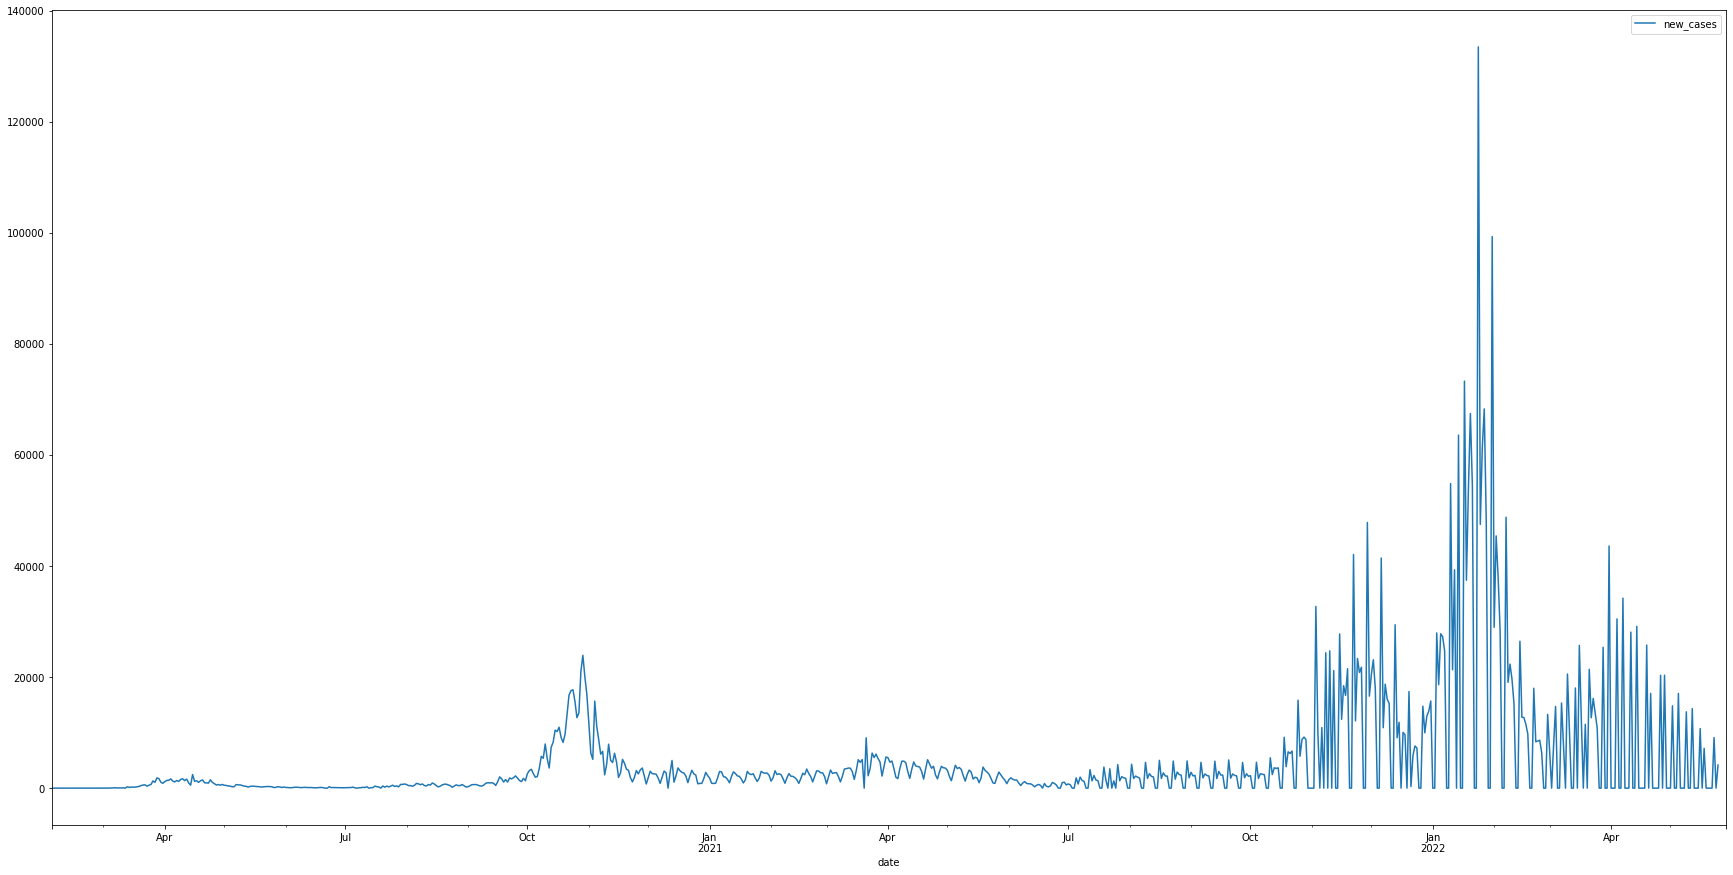

In [84]:
#create new dataframe covid19_be that only contains the new cases from Belgium
covid19_be = covid19[covid19['location'] == 'Belgium']
covid19_be = covid19_be['new_cases'].to_frame()
covid19_be.plot(figsize=(30,15))

## Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

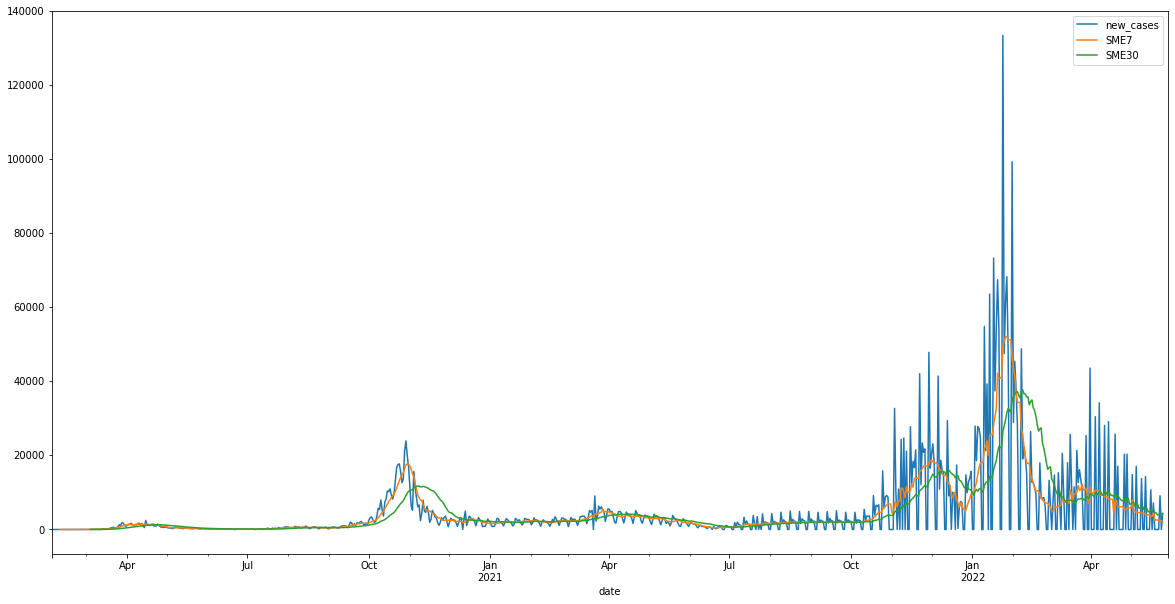

In [85]:
covid19_be["SME7"] = covid19_be["new_cases"].rolling(window=7).mean()
covid19_be["SME30"] = covid19_be["new_cases"].rolling(window=30).mean()
covid19_be.plot(y=["new_cases", "SME7", "SME30"], figsize=(20,10));

In [80]:
covid19_be

,new_cases,SMA7,SMA30
date,,,
2020-02-04,1.0,NaN,NaN
2020-02-05,0.0,NaN,NaN
2020-02-06,0.0,NaN,NaN
2020-02-07,0.0,NaN,NaN
2020-02-08,0.0,NaN,NaN
...,...,...,...
2022-05-25,4160.0,1896.428571,4392.566667
2022-05-26,NaN,NaN,NaN
2022-05-27,NaN,NaN,NaN


## Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

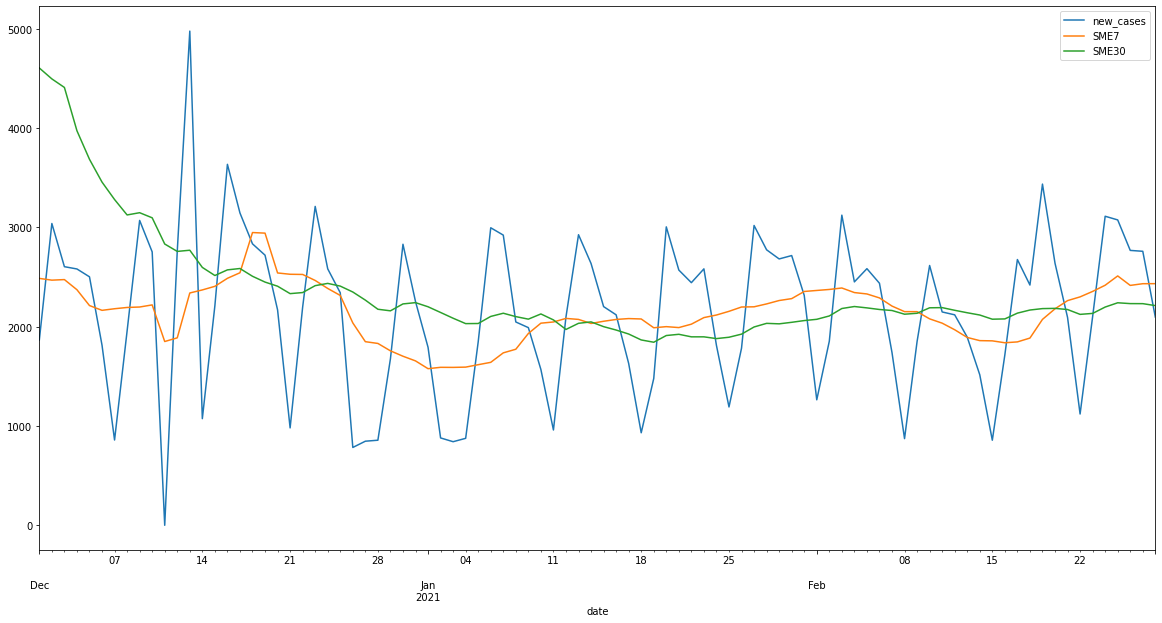

In [86]:
covid19_beDecFeb = covid19_be[(covid19_be.index >= "2020-12-1") & (covid19_be.index <= "2021-02-28")]

covid19_beDecFeb.plot(y=["new_cases", "SME7", "SME30"], figsize=(20,10));



Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\szymo\AppData\Local\Temp\ipykernel_20752\2686285420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_beDecFeb["SES"] = ses.fittedvalues


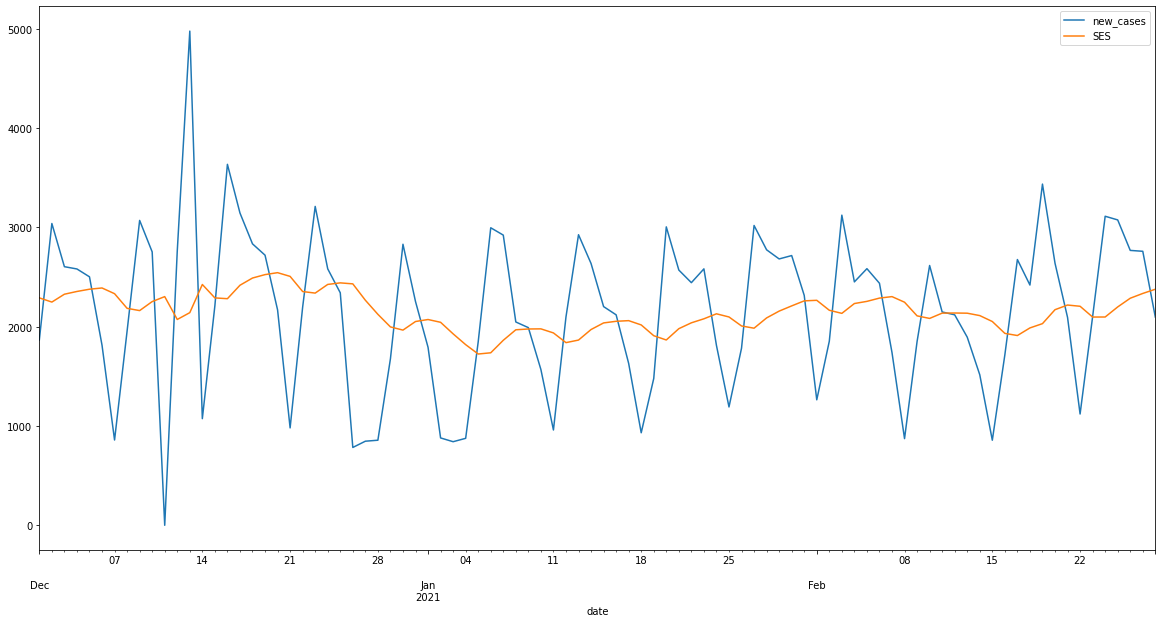

In [87]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses = SimpleExpSmoothing(covid19_beDecFeb["new_cases"]).fit(smoothing_level=0.1)
covid19_beDecFeb["SES"] = ses.fittedvalues

covid19_beDecFeb.plot(y=["new_cases", "SES"], figsize=(20,10));

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\szymo\AppData\Local\Temp\ipykernel_20752\2092309766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_beDecFeb["DES"] = des.fittedvalues


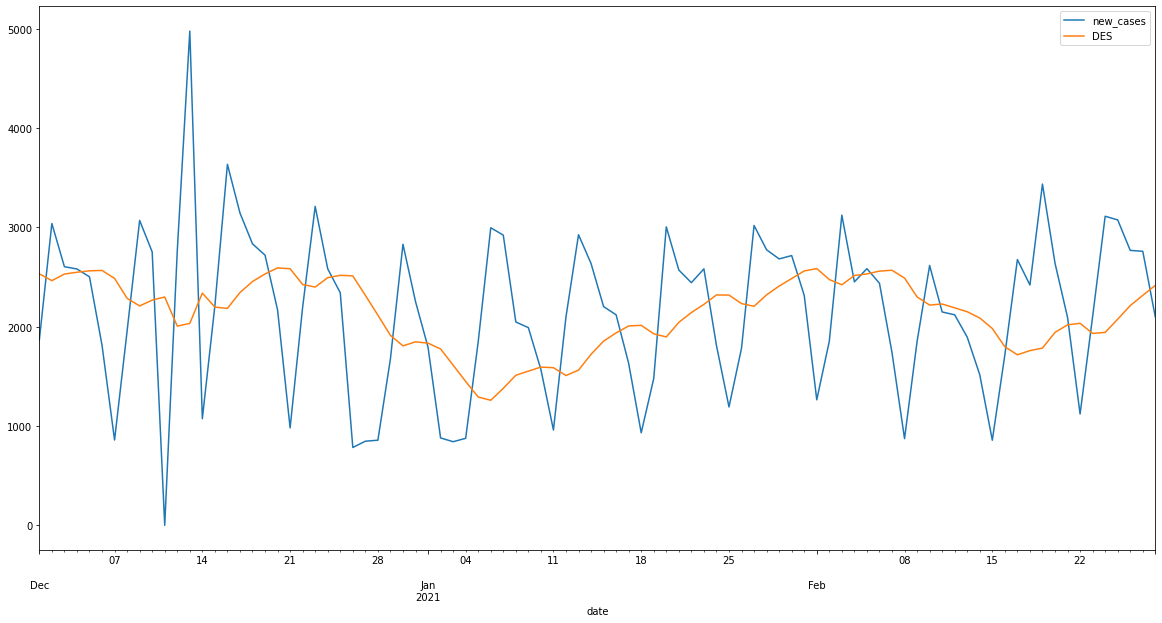

In [88]:
from statsmodels.tsa.api import Holt

des = Holt(covid19_beDecFeb["new_cases"]).fit(smoothing_level=0.1, smoothing_trend=0.2)
covid19_beDecFeb["DES"] = des.fittedvalues

covid19_beDecFeb.plot(y=["new_cases", "DES"], figsize=(20,10));

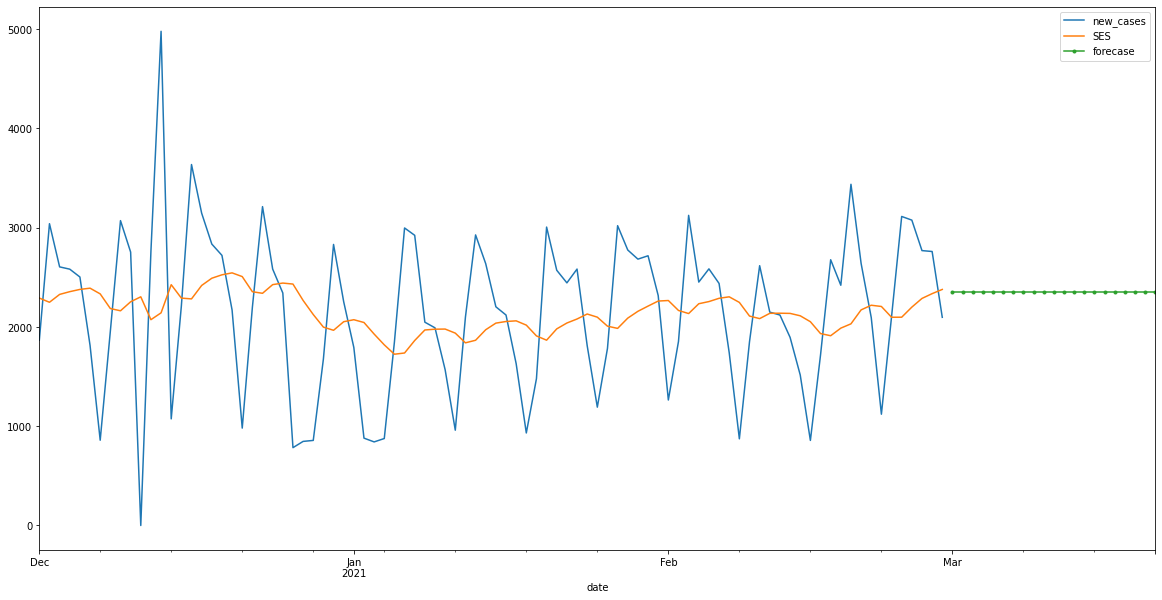

In [89]:
SESForecast = ses.forecast(21)

covid19_beDecFeb.plot(y=["new_cases", "SES"], figsize=(20,10));
SESForecast.plot(marker='.', label="forecase", legend=True);

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

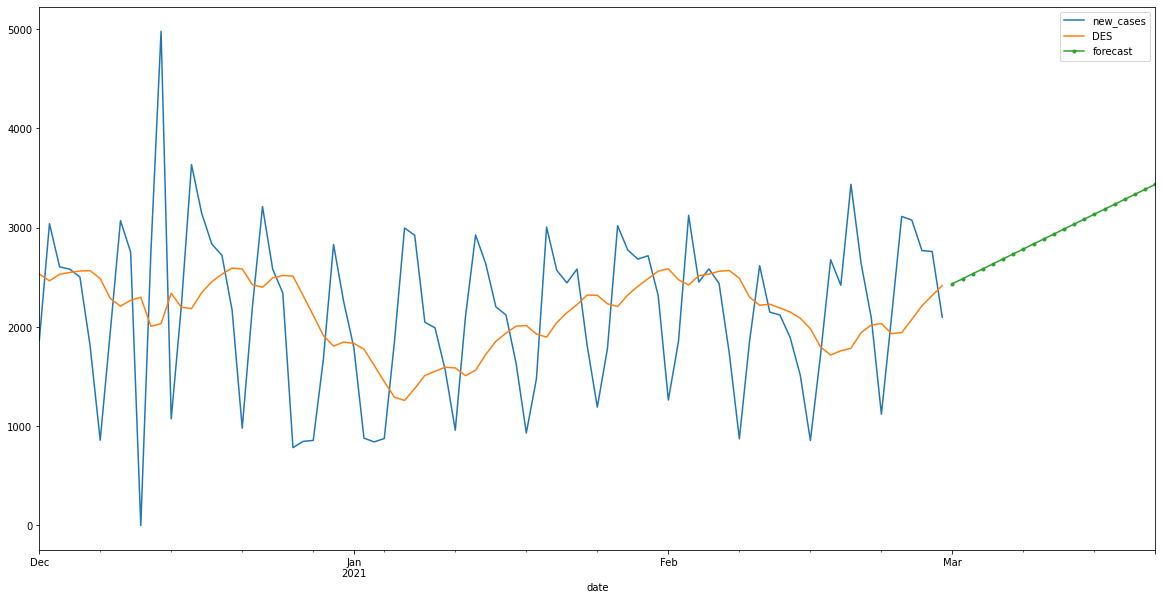

In [90]:
DESForecast = des.forecast(21)

covid19_beDecFeb.plot(y=["new_cases", "DES"], figsize=(20,10));
DESForecast.plot(marker=".", label="forecast", legend=True);

## Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   64617.220 |  254.199 |  811.826 |
| 2021-03-01 to 2021-03-14 |  208014.899 |  456.087 |  837.483 |
| 2021-03-01 to 2021-03-21 | 3228834.183 | 1796.896 | 1154.486 |

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


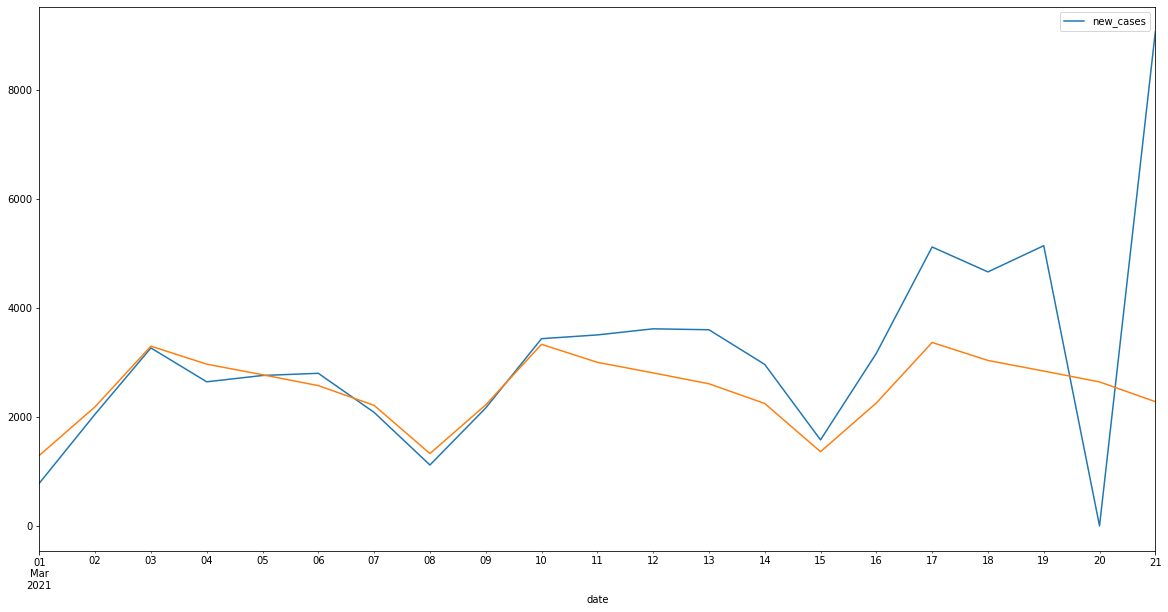

In [91]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = covid19_beDecFeb["new_cases"]
holt_winter = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=7).fit()
predicted = holt_winter.forecast(21)


testdata = covid19_be[(covid19_be.index >= "2021-03-01") & (covid19_be.index <= "2021-03-21")]["new_cases"].to_frame()
testdata

testdata.plot(figsize=(20,10));
predicted.plot();

In [92]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MSE = {mean_squared_error(testdata, predicted)}')
print(f'√MSE  = {np.sqrt(mean_squared_error(testdata, predicted))}')
print(f'stdev = {testdata.new_cases.std()}')

MSE = 3228834.1832377026
√MSE  = 1796.8957073903046
stdev = 1893.7697489147836


### 2021-03-01 to 2021-03-07

### 2021-03-01 to 2021-03-14

### 2021-03-01 to 2021-03-21

## ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

In [95]:
covid19_be = covid19[covid19['location'] == 'Belgium']

<AxesSubplot:xlabel='date'>

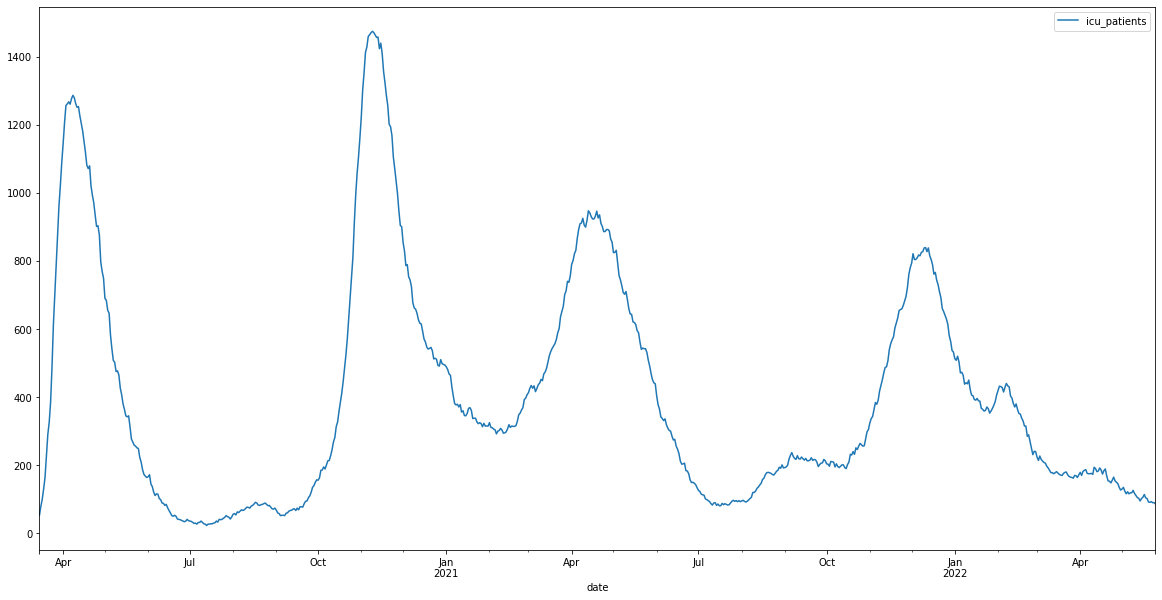

In [98]:
icu = covid19_be['icu_patients'].dropna().to_frame()
icu.plot(figsize=(20,10))

In [99]:
icu

,icu_patients
date,
2020-03-15,53.0
2020-03-16,79.0
2020-03-17,100.0
2020-03-18,130.0
2020-03-19,164.0
...,...
2022-05-21,91.0
2022-05-22,93.0
2022-05-23,90.0


Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

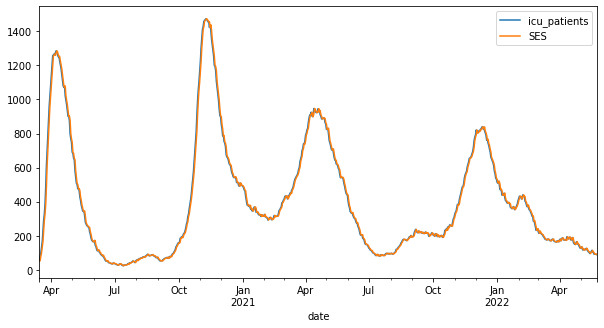

In [103]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ses = SimpleExpSmoothing(icu['icu_patients']).fit()
icu['SES'] = ses.fittedvalues
icu.plot(y=['icu_patients',  'SES'], figsize=[10,5])



<AxesSubplot:xlabel='date'>

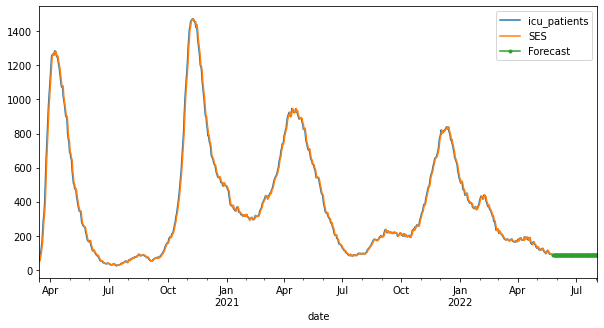

In [105]:
icu_ses_fcast =ses.forecast(70)

icu.plot(y=['icu_patients',  'SES'], figsize=[10,5])
icu_ses_fcast.plot(marker='.', legend=True, label='Forecast')

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

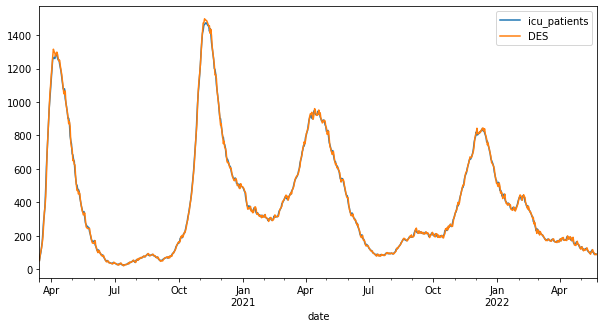

In [107]:
from statsmodels.tsa.api import Holt

des = Holt(icu['icu_patients']).fit()

icu['DES'] = des.fittedvalues
icu.plot( y=['icu_patients',  'DES'], figsize=[10,5])


<AxesSubplot:xlabel='date'>

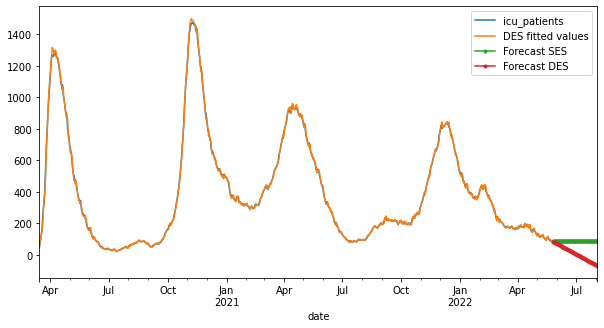

In [110]:
icu_des_fcast = des.forecast(70)

icu['icu_patients'].plot( legend=True) # Observations
icu['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
icu_ses_fcast.plot(marker='.', legend=True, label='Forecast SES')
icu_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

In [112]:
des.summary()

Dep. Variable:,icu_patients,No. Observations:,802
Model:,Holt,SSE,121253.082
Optimized:,True,AIC,4032.858
Trend:,Additive,BIC,4051.607
Seasonal:,None,AICC,4032.964
Seasonal Periods:,None,Date:,"Mon, 30 May 2022"
Box-Cox:,False,Time:,21:17:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9583341,alpha,True
smoothing_trend,0.3899039,beta,True


What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

In [ ]:
#SL = 0.958
#SM = 0.389

Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

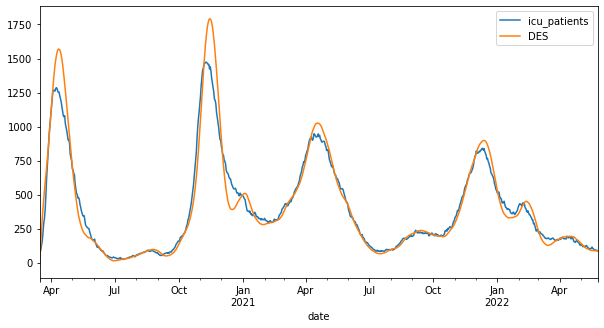

In [113]:
from statsmodels.tsa.api import Holt

des = Holt(icu['icu_patients']).fit(smoothing_level=0.1, smoothing_trend=0.2)

icu['DES'] = des.fittedvalues
icu.plot( y=['icu_patients',  'DES'], figsize=[10,5])

<AxesSubplot:xlabel='date'>

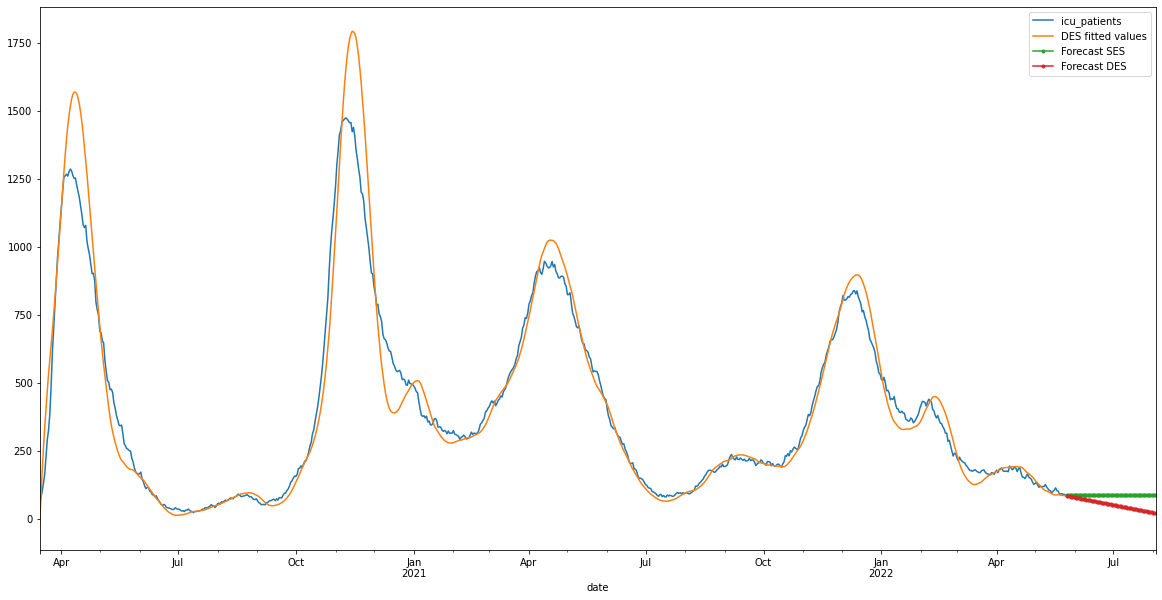

In [116]:
icu_des_fcast = des.forecast(70)

icu['icu_patients'].plot( legend=True) # Observations
icu['DES'].plot(legend=True, label='DES fitted values', figsize=[20,10])              
icu_ses_fcast.plot(marker='.', legend=True, label='Forecast SES')
icu_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?

In [115]:
des.summary()

Dep. Variable:,icu_patients,No. Observations:,802
Model:,Holt,SSE,6005691.703
Optimized:,True,AIC,7162.730
Trend:,Additive,BIC,7181.478
Seasonal:,None,AICC,7162.836
Seasonal Periods:,None,Date:,"Mon, 30 May 2022"
Box-Cox:,False,Time:,21:18:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
smoothing_trend,0.2000000,beta,False
